In [60]:
import os, sys

import pathlib
import pandas as pd
import numpy as np
from easydict import EasyDict as edict
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import time


In [61]:
dir_path = pathlib.Path().absolute()
file = '../data/imputed_data.csv'
data_path = os.path.join(dir_path, file)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df = pd.read_csv(data_path  ,index_col=False).drop(['Unnamed: 0'], axis=1)
df.reset_index(drop=True, inplace=True)
assert df.isnull().sum().sum() == 0

df.drop(columns=['SPI_X1','SPI_Y1','SPI_X2','SPI_Y2','SPI_L1','SPI_W1','SPI_L2','SPI_W2'], inplace=True)
df.head(10)

,CRD,PartType,Orient.,X,Y,SPI_X_AVG,SPI_Y_AVG,SPI_L,SPI_W,PRE_X,PRE_Y,PRE_A,PRE_L,PRE_W,POST_X,POST_Y,POST_A,POST_L,POST_W,Job,Chip_L,Chip_W,SPI_VOLUME_MEAN
0,B1,R0402,90.0,31.26,100.11,-52.00,61.90,61.90,52.00,-19.887293,-1.840963,-1.877,-1.840963,19.887293,-7.440417,28.108231,1.613,28.108231,7.440417,CENTER,400.0,200.0,78.71525
1,B2,R0402,90.0,31.83,100.11,-47.00,63.70,63.70,47.00,-26.766272,6.898049,-1.449,6.898049,26.766272,5.487133,22.242701,0.000,22.242701,-5.487133,CENTER,400.0,200.0,77.33190
2,B3,R0402,90.0,32.40,100.11,-41.60,72.35,72.35,41.60,-32.058273,8.125244,-3.278,8.125244,32.058273,-19.644203,12.971593,1.552,12.971593,19.644203,CENTER,400.0,200.0,77.17380
3,B4,R0402,90.0,32.97,100.11,-50.60,63.10,63.10,50.60,-23.437572,-6.195457,-3.337,-6.195457,23.437572,-22.517658,26.396389,0.000,26.396389,22.517658,CENTER,400.0,200.0,77.96495
4,B5,R0402,90.0,33.54,100.11,-50.00,69.45,69.45,50.00,-5.187286,7.085744,-3.408,7.085744,5.187286,-21.413681,29.193306,3.611,29.193306,21.413681,CENTER,400.0,200.0,75.37700
5,B6,R0402,90.0,31.26,99.20,-49.10,59.75,59.75,49.10,-31.059980,1.531298,3.611,1.531298,31.059980,-5.925862,17.682121,0.000,17.682121,5.925862,CENTER,400.0,200.0,77.66230
6,B7,R0402,90.0,31.83,99.20,-44.95,60.10,60.10,44.95,-20.728939,10.258562,-3.247,10.258562,20.728939,-17.024027,33.615910,3.455,33.615910,17.024027,CENTER,400.0,200.0,77.56575
7,B8,R0402,90.0,32.40,99.20,-39.05,70.00,70.00,39.05,-27.195978,11.357373,-2.031,11.357373,27.195978,-1.401807,29.627155,3.337,29.627155,1.401807,CENTER,400.0,200.0,79.10090
8,B9,R0402,90.0,32.97,99.20,-46.55,62.45,62.45,46.55,-19.822590,1.057152,-3.047,1.057152,19.822590,-20.989681,15.195607,3.310,15.195607,20.989681,CENTER,400.0,200.0,81.96445
9,B10,R0402,90.0,33.54,99.20,-53.25,71.15,71.15,53.25,-26.842043,3.604794,-3.022,3.604794,26.842043,-17.169552,31.046926,-1.660,31.046926,17.169552,CENTER,400.0,200.0,79.36680


In [62]:
# switch 90 data to 0 data
def switchOrient(x90, y90):
    y0 = float(x90)
    x0 = float(-y90)
    return x0, y0 

In [63]:
ABSOLUTE_ANGLE = True
BY_CHIP_PERCENTAGE = True
PRE_OR_POST_ANGLE = 'pre'
DISTANCE = 'spi' # [DISTANCE] - POST 
STOP_AFTER = 10 # rows

dfgroups = df.groupby(['PartType']) 

filtering criteria
1. group by chip
2. condition
3. post and pre save
4. plot

In [64]:
start = time.time()

pre = edict()
post = edict()
pre_post_case = edict()

NUM_CASES = 2 # 2, 8, 6
for i, (chiptype, group) in enumerate(dfgroups):
    print(chiptype,'...')
    
    pre[f'{chiptype}'] = []
    post[f'{chiptype}'] = []
    
    pre_post_case[f'{chiptype}'] = \
        [pd.DataFrame(columns=['dist_pre','dist_post']) for i in range(NUM_CASES)]
    
    t = tqdm(group.iterrows(), total=len(group))
    for idx, row in t:
        t.set_description(f'Row: {idx}')
        case = -1
        
        spi_x_avg, spi_y_avg = row[['SPI_X_AVG','SPI_Y_AVG']]
        pre_x, pre_y, post_x, post_y = row[['PRE_X','PRE_Y','POST_X','POST_Y']]
        orientation = row['Orient.']
        
        ''' rotate 90 to 0 '''
        if orientation == 90:
            pre_x, pre_y = switchOrient(pre_x, pre_y)
            post_x, post_y = switchOrient(pre_x, pre_y)
            spi_x_avg, spi_y_avg = switchOrient(spi_x_avg, spi_y_avg)
        
        pre_norm = np.linalg.norm((pre_x, pre_y))
        post_norm =  np.linalg.norm((post_x, post_y))
        spi_norm =  np.linalg.norm((spi_x_avg, spi_y_avg))
        
        pre[f'{chiptype}'].append(pre_norm)
        post[f'{chiptype}'].append(post_norm)
        values_to_add = [pre_norm, post_norm]
        
        if spi_norm <= post_norm:
            case = 0
        else:
            case = 1
            
#         print(spi_x_avg,spi_y_avg,post_x, post_y, spi_norm, post_norm)
        ''' append distance and angle by condition and quadrant for SPI and Post (Chip) '''
        # df_chips_cond_quad
        # case 1: SPI offset is (+, +), Post offset is (+,+), SPI offset <= Post offset
#         if spi_x_avg >= 0 and spi_y_avg >= 0 and post_x >= 0 and post_y >= 0 \
#             and spi_norm <= post_norm:
#             case = 0
#         # case 2: SPI offset is (+, +), Post offset is (+,+), SPI offset > Post offset
#         elif spi_x_avg >= 0 and spi_y_avg >= 0 and post_x >= 0 and post_y >= 0 \
#             and spi_norm > post_norm:
#             case = 1
#         # case 3: SPI offset is (-, +), Post offset is (-,+), SPI offset <= Post offset
#         elif spi_x_avg <= 0 and spi_y_avg >= 0 and post_x <= 0 and post_y >= 0 \
#             and spi_norm <= post_norm:
#             case = 2
#         # case 4: SPI offset is (-, +), Post offset is (-,+), SPI offset  > Post offset
#         elif spi_x_avg <= 0 and spi_y_avg >= 0 and post_x <= 0 and post_y >= 0 \
#             and spi_norm > post_norm:
#             case = 3
#         # case 5: SPI offset is (-, -), Post offset is (-, -), SPI offset <= Post offset
#         elif spi_x_avg <= 0 and spi_y_avg <= 0 and post_x <= 0 and post_y <= 0 \
#             and spi_norm <= post_norm:
#             case = 4
#         # case 6: SPI offset is (-, -), Post offset is (-, -), SPI offset > Post offset
#         elif spi_x_avg <= 0 and spi_y_avg <= 0 and post_x <= 0 and post_y <= 0 \
#             and spi_norm > post_norm:
#             case = 5
#         # case 7: SPI offset is (+, -), Post offset is (+,-), SPI offset <= Post offset
#         elif spi_x_avg >= 0 and spi_y_avg <= 0 and post_x >= 0 and post_y <= 0 \
#             and spi_norm <= post_norm:
#             case = 6
#         # case 8: SPI offset is (+, -), Post offset is (+,-), SPI offset > Post offset
#         elif spi_x_avg >= 0 and spi_y_avg <= 0 and post_x >= 0 and post_y <= 0 \
#             and spi_norm > post_norm:
#             case = 7
        
        ''' append based on alignment'''
#         if spi_x_avg >= 0 and spi_y_avg > 0 and post_x >= 0 and post_y >= 0 \
#             and spi_norm <= post_norm:
#             case = 0
#         # case 2a: SPI offset is (-, -), Post offset is (-, -), SPI offset <= Post offset
#         elif spi_x_avg <= 0 and spi_y_avg <= 0 and post_x <= 0 and post_y <= 0 \
#             and spi_norm <= post_norm:
#             case = 1
#         # case 2b: SPI offset is (-, -), Post offset is (-, -), SPI offset > Post offset
#         elif spi_x_avg <= 0 and spi_y_avg <= 0 and post_x <= 0 and post_y <= 0 \
#             and spi_norm > post_norm:
#             case = 2  
#         # case 3: SPI offset is (-, +), Post offset is (-,+), SPI offset <= Post offset      
#         elif spi_x_avg <= 0 and spi_y_avg >= 0 and post_x <= 0 and post_y >= 0 \
#             and spi_norm <= post_norm:
#             case = 3
#         # case 4a: SPI offset is (+, -), Post offset is (+,-), SPI offset <= Post offset
#         elif spi_x_avg >= 0 and spi_y_avg <= 0 and post_x >= 0 and post_y <= 0 \
#             and spi_norm <= post_norm:
#             case = 4
#         # case 4b: SPI offset is (+, -), Post offset is (+,-), SPI offset > Post offset
#         elif spi_x_avg >= 0 and spi_y_avg <= 0 and post_x >= 0 and post_y <= 0 \
#             and spi_norm > post_norm:
#             case = 5
        
        
        if case != -1:
            pre_post_case[f'{chiptype}'][case].loc[len(pre_post_case[f'{chiptype}'][case]),:] = values_to_add
        
print(f'It took {time.time() - start} seconds')

Row: 71:   0%|          | 29/60750 [00:00<03:31, 287.31it/s]

R0402 ...


Row: 831:   0%|          | 27/60750 [00:00<03:46, 267.72it/s]

R0603 ...


Row: 1581:   0%|          | 34/60750 [00:00<02:59, 338.71it/s]

R1005 ...


Row: 182249: 100%|██████████| 60750/60750 [02:52<00:00, 353.04it/s]

It took 515.7668631076813 seconds


In [65]:
img_path = './pre_post_offset_condition1'
if not os.path.exists(img_path):
    os.makedirs(img_path)

In [66]:
# save as pickle
import pickle5 as pickle
with open(f'{img_path}/pre_post_case.p', 'wb') as fp:
    pickle.dump(pre_post_case, fp, protocol=pickle.HIGHEST_PROTOCOL)


In [67]:
# load pickle
import pickle5 as pickle
pre_post_case = pickle.load(open(f'{img_path}/pre_post_case.p', 'rb'))

In [68]:
chips = ['R0402','R0603','R1005']
for chip in chips:
    for case in range(NUM_CASES):
        pre_post_case[chip][case] = pd.DataFrame(pre_post_case[chip][case], columns=['dist_pre','dist_post'],dtype=float)

chip: R0402, case: 0, post > pre: 877 	post <= pre: 13916
chip: R0402, case: 1, post > pre: 6129 	post <= pre: 39828

chip: R0603, case: 0, post > pre: 278 	post <= pre: 15191
chip: R0603, case: 1, post > pre: 3171 	post <= pre: 42110

chip: R1005, case: 0, post > pre: 38 	post <= pre: 13910
chip: R1005, case: 1, post > pre: 2204 	post <= pre: 44598



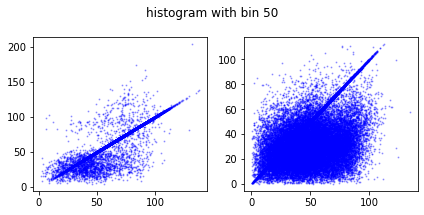

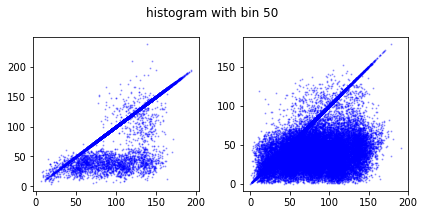

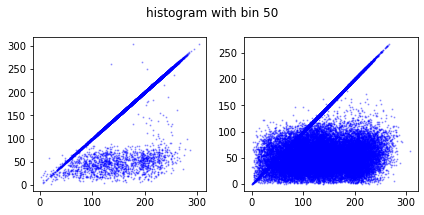

In [71]:
# visualize

import warnings
warnings.filterwarnings("ignore")
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable


histogram_bin_size = 50

for i, chip in enumerate(chips):
    fig = plt.figure(figsize=(6,3)) # condition 1
#     fig = plt.figure(figsize=(6,12)) # 8 cases 
#     fig = plt.figure(figsize=(6,9))  # condition 2
    ax = {}
    for j, case in enumerate(range(NUM_CASES)):
        ax[j] = fig.add_subplot(NUM_CASES/2, 2, j+1)
        
#         img = ax[j].scatter(pre_post_case[chip][case].iloc[:,0], pre_post_case[chip][case].iloc[:,1], s=1, alpha=0.3, color='b', label=chip)
#         ax[j].plot(pre_post_case[chip][case].iloc[:,0],pre_post_case[chip][case].iloc[:,0], 'k-', color='gray', label='|PRE|=|POST|')

        # 2d histogram
        heatmap, xedges, yedges = np.histogram2d(pre_post_case[chip][case].iloc[:,0].to_numpy(), \
                                                 pre_post_case[chip][case].iloc[:,1].to_numpy(), \
                                                 bins=histogram_bin_size)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        img = ax[j].imshow(heatmap.T, extent=extent, origin='lower',cmap=cm.jet) #cmap=cm.PuBu_r)
        
        ax[j].set_ylim([0, 100])
        ax[j].set_xlim([0, 100])
        ax[j].set_title(f'{chip}_case_{case+1}')
#         ax[j].legend(loc='upper left')
        ax[j].grid()
        ax[j].set_xlabel('Pre-AOI Offset (\u03BCm)')
        ax[j].set_ylabel('Post-AOI Offset (\u03BCm)')
        
        divider = make_axes_locatable(ax[j])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(img, ax=ax[j], cax=cax)
        
        # compute statistics
        predist = pre_post_case[chip][case].iloc[:,0].to_numpy()
        postdist = pre_post_case[chip][case].iloc[:,1].to_numpy()
        count = 0
        for pre, post in zip(predist, postdist):
            if post > pre:
                count += 1
        print(f'chip: {chip}, case: {case}, post > pre:', count, '\tpost <= pre:', len(predist)-count)
        
    print()
       
    fig.suptitle(f'histogram with bin {histogram_bin_size}', fontsize=12)
    fig.tight_layout()    
    fig.savefig(f'./{img_path}/{chip}_pre_post_offsets.png')


    